# Suncharts

It's obvious that exactly half of the earth is illuminated by the sun at any given time. The zone between day and night is called *the Terminator*.  If you've been on an intercontinental flight, you might have seen this illustrated as a map with a light part and a dark part, separated by a curved boundary. This boundary is always, in fact, a circle in 3d space, and the curved shape arises from the map projection. Let's see if we can recreate that shape!

First off, we'll need some tools:

In [1]:
from PIL import Image, ImageDraw, ImageFilter, ImageFont
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from math import sqrt,sin,cos,tan,atan,atan2,pi,degrees,radians,acos
from collections import namedtuple
from matplotlib.pyplot import imshow

%matplotlib inline

FONT = ImageFont.truetype("Ubuntu-LI.ttf", 20)

We'll use a named tuple for representing 3d coordinates:

In [3]:
Coords = namedtuple("Coords", ["x", "y", "z"])

We'll assume that the earth is a perfect sphere, which means that we don't have to worry about a varying radius. In real life, earth is an oblate spheroid, with a given point on the equator being slightly further from the core than a point on the poles, due to rotation.

Since we don't care about the radius, we can describe any given point using two coordinates, rather than three: longitude and latitude. We declare a simple function for calculating the cartesian 3d coordinates from these. This is simply the formulas for spherical coordinates, with the radius set to one.

In [4]:
def normal_vector(theta, phi):
    return Coords(sin(theta)*cos(phi), sin(theta)*sin(phi), cos(theta))

Consider a line from the core of the sun, to the core of the earth. Then construct a plane on the earth end which is perpendicular to the line. The intersection of the earth and our plane represents the the transition from day to night and vice versa. We want to derive a relationship which, given a normal vector indicating the location of the sun, allows us to calculate the latitude of the day-night boundary as a function of longitude.

A generalized plane is defined by $n\cdot(r-r_0)=0$, with $n$ being a normal vector, $r$ being any point on the plane, and $r_0$ being a fixed reference point. We'll use the origin for $r_0$, which allows us to disregard it.

$$n \cdot r=0$$

We also know of our relationships between spherical and cartesian coordinates:

$$\begin{cases} x=\sin \theta \cos \phi \\
y=\sin \theta \sin \phi \\
z=\cos \theta \end{cases}$$

Substituing these relationships into the equation of a plane, we find:

$$\begin{array} {lcl} n_x \sin \theta \cos \phi + n_y \sin \theta \sin \phi + n_z \cos \theta = 0 \\
\sin \theta(n_x \cos \phi + n_y \sin \phi) + n_z \cos \theta = 0 \\
\sin \theta(n_x \cos \phi + n_y \sin \phi) = -n_z \cos \theta \end{array}$$

Which yields our sought relationship:

$$tan(\theta) = -\displaystyle \frac{n_z}{n_x cos(\phi) + n_y sin(\phi)}$$
    
We'll implement this as a first class function, which accepts a normal vector as a parameter, and returns a function which given phi (longitude) will return theta (latitude).

In [5]:
def intersect_plane(n):
    def plane(phi):
        return -atan2(n.z, (n.x*cos(phi) + n.y*sin(phi)))
        
    return plane

Let's do a quick sanity check. When the axis of earths rotation is pointing directly towards the sun, we should see a bell shaped curve.

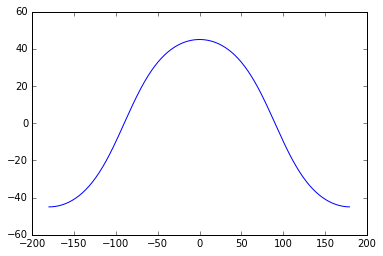

In [6]:
# our normal vector indicates the location of the sun
n = normal_vector(radians(45), radians(0))
# we use our intersect_plane method to create a function that describes 
# the terminator
plane = intersect_plane(n)

# calculate our function value all around the earth
phi = xrange(-180, 180)
theta = [90 + degrees(plane(radians(x))) for x in phi]

plt.plot(phi, theta)
plt.show()

The particulars aren't quite right here, but we'll move on and figure it out later. Next, we'll overlay it on a map.

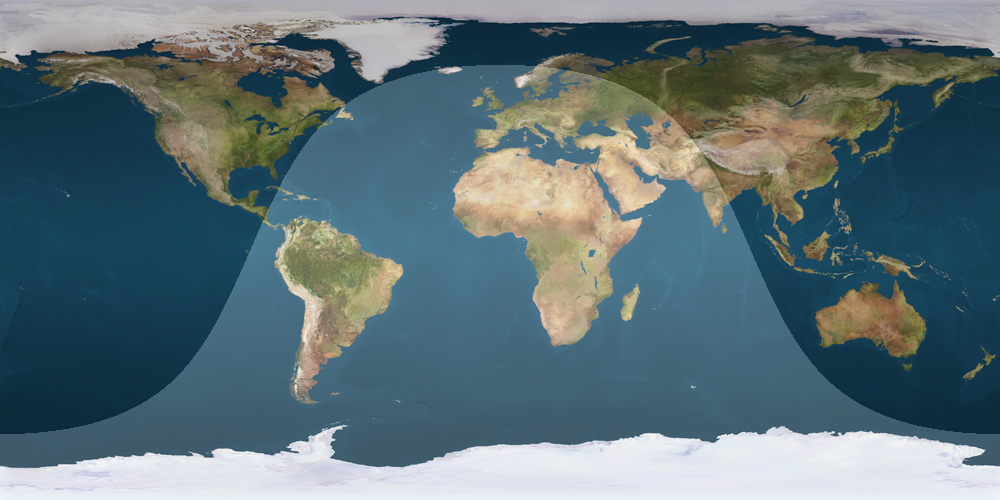

In [7]:
def plot_map(n):
    plane = intersect_plane(n)

    # load our map
    img = Image.open("earthmap1k.jpg")
    w, h = img.size
    
    # create a second image of the same size
    img2 = Image.new("RGB", img.size)

    # draw the dark part onto our second image
    draw = ImageDraw.Draw(img2)
    for x in xrange(0, w):
        # calculate our longitude based on the current pixel column under
        # consideration
        phi = pi*(x-w/2)/float(w/2)
        theta = plane(phi)
        if theta < 0:
            y = h/2 - h*(pi/2+theta)/(pi)
            draw.line((x, y, x, h), fill=(255, 255, 255))
        else:
            y = h/2 - h*(pi/2-theta)/(pi)
            draw.line((x, 0, x, y), fill=(255, 255, 255))
    del draw
    
    # blend the images together
    return Image.blend(img, img2, 0.2)

# 23.5 is the tilt of the earth axis
n = normal_vector(radians(90-23.5), radians(0))
plot_map(n)

So far, we've used rather arbitrary normal vectors, and correctly accounting for the axial tilt of the earth, and the position of the earth relative to the sun, is a bit tricky. Let's tackle the problem in it's full complexity!

First off, we a function for calculating the angle between two vectors.

In [8]:
# the angle between two vectors can be found using a*b = |a||b|cos(alpha),
# * being the dot product
def angle(a,b):
    return acos(np.dot(a,b)/(norm(a)*norm(b)))

We'll also need a way of projecting a vector onto a plane. I cheated and [looked it up](http://www.euclideanspace.com/maths/geometry/elements/plane/lineOnPlane/index.htm). `n` defines our plane, while p is our vector.

$$n \times \overline{n \times p}$$

In [9]:
def project_to_plane(n, p):
    q = np.cross(n, p)
    l = norm(q)
    q2 = (q[0]/l, q[1]/l, q[2]/l)
    return np.cross(n, q2)

Here's the work horse of our project. This function calculates the *apparent* axial tilt, based on true axial tilt, and position relative to the sun.

In [10]:
def axis_angle_at_theta(theta):
    # this vector points straight up, towards the pool
    up = normal_vector(radians(0), radians(0))
    # this vector points through the equator, towards the sun
    d = normal_vector(radians(90), theta)
    # We now construct a third vector, which still points towards 
    # the equator, but perpendicular to the first two. We'll consider
    # this vector to describe a plane through origo.
    solar_plane = np.cross(up, d)

    # next, let's set up a vector indicating the axial tilt of the earth.
    axial_tilt = normal_vector(radians(23.4392811), radians(0))
    
    # This is the trick: We'll project our vector indicating axial tilt
    # onto our plane. 
    r = project_to_plane(solar_plane, axial_tilt)
    
    # Finally, we can compute the angle between our projected axial tilt
    # vector, and the true axial tilt, to find our apparent tilt.
    a = angle(r, axial_tilt)
    if theta < 0: return a-pi
    else: return pi-a

All that remains is to plot our map at regular intervals.

In [11]:
def day_to_human_readable(day):
    day = day % 365
    
    months = [
        ("January", 31),
        ("February", 28),
        ("March", 31),
        ("April", 30),
        ("May", 31),
        ("June", 30),
        ("July", 31),
        ("August", 31),
        ("September", 30),
        ("October", 31),
        ("November", 30),
        ("December", 31)
    ]
    
    month = 0
    while day >= months[month][1]:
        day -= months[month][1]
        month += 1
        
    return months[month][0] + " " + str(day+1)

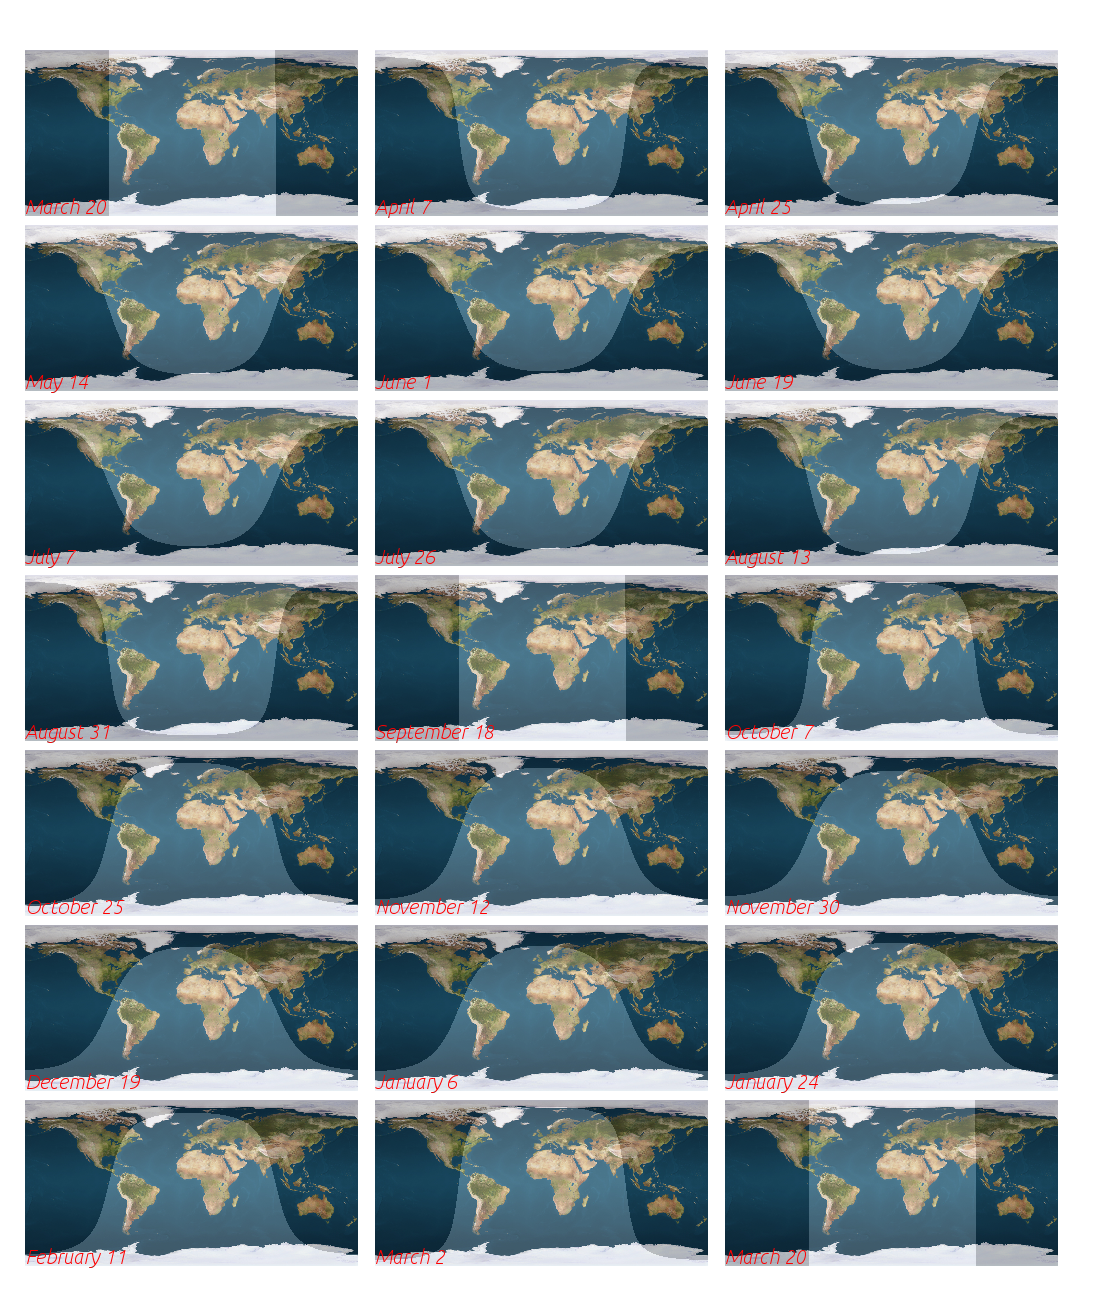

In [12]:
img = Image.new("RGBA", (1100, 1300))
d = ImageDraw.Draw(img)
steps = 20
step_size = 360/steps
for i in xrange(0, steps+1):
    theta = i*step_size - 180
    day_of_year = int((i+4.3)*365/float(steps))
    date_text = day_to_human_readable(day_of_year)
    row, col = i/3, i%3
    x, y = 25 + col*350, 50 + row*175
    
    a = pi/2-axis_angle_at_theta(radians(theta))
    
    # phi describes what longitude we want to center on
    phi = radians(0)
    if a > pi/2:
        phi -= pi
    
    res = plot_map(normal_vector(a, phi))
    res = res.resize((res.size[0]/3, res.size[1]/3))
    img.paste(res, (x, y))
    
    d.text((x,y+145), date_text, font=FONT, fill=(255,0,0,255))
    
img

We can also write a sequence of frames to disk, in order to generate an animation.